In [ ]:
# https://www.kaggle.com/kappa420/districts
# https://colorado.hometownlocator.com/zip-codes/zipcodes,city,denver.cfm
# https://www.climate.gov/maps-data/dataset/past-weather-zip-code-data-table
# https://www.usclimatedata.com/climate/denver/colorado/united-states/usco0105
# http://benalexkeen.com/resampling-time-series-data-with-pandas/
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import statsmodels as sm
import matplotlib.pylab as plb

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from pandas.plotting import register_matplotlib_converters
from scipy.stats import norm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from stldecompose import decompose
from stldecompose import forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)

pd.plotting.register_matplotlib_converters()

%matplotlib inline

In [40]:
denverCrime_df = pd.read_csv('DenverCrime.csv')

In [41]:
denverCrime_df.head()

,INCIDENT_ID,OFFENSE_ID,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC
0,2016376978,2016376978521300,5213,0,weapon-unlawful-discharge-of,all-other-crimes,6/15/2016 11:31:00 PM,NaN,6/15/2016 11:31:00 PM,NaN,3193983.0,1707251.0,-104.809881,39.773188,5,521,montbello,1,0
1,20186000994,20186000994239900,2399,0,theft-other,larceny,10/11/2017 12:30:00 PM,10/11/2017 4:55:00 PM,1/29/2018 5:53:00 PM,NaN,3201943.0,1711852.0,-104.781434,39.785649,5,522,gateway-green-valley-ranch,1,0
2,20166003953,20166003953230500,2305,0,theft-items-from-vehicle,theft-from-motor-vehicle,3/4/2016 8:00:00 PM,4/25/2016 8:00:00 AM,4/26/2016 9:02:00 PM,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,3,314,wellshire,1,0
3,201872333,201872333239900,2399,0,theft-other,larceny,1/30/2018 7:20:00 PM,NaN,1/30/2018 10:29:00 PM,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,3,312,belcaro,1,0
4,2017411405,2017411405230300,2303,0,theft-shoplift,larceny,6/22/2017 8:53:00 PM,NaN,6/23/2017 4:09:00 PM,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,3,311,cherry-creek,1,0


In [42]:
# convert the occurrence date to DT format and make as index
denverCrime_df.FIRST_OCCURRENCE_DATE = pd.to_datetime(denverCrime_df.FIRST_OCCURRENCE_DATE)
# denverCrime_df.index = pd.DatetimeIndex(denverCrime_df["FIRST_OCCURRENCE_DATE"])

In [43]:
# remove columns that are either unnecessary for analysis or are to be converted to one hot (will be re-inserted after conversion)

denverCrime_df2 = denverCrime_df.drop(columns=['INCIDENT_ID','OFFENSE_ID','OFFENSE_CODE','OFFENSE_CODE_EXTENSION',
                                          'OFFENSE_TYPE_ID','OFFENSE_CATEGORY_ID',
                                          'LAST_OCCURRENCE_DATE','REPORTED_DATE','PRECINCT_ID','DISTRICT_ID',
                                          'IS_CRIME','IS_TRAFFIC'])

In [44]:
denverCrime_df2.head()

,FIRST_OCCURRENCE_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,NEIGHBORHOOD_ID
0,2016-06-15 23:31:00,NaN,3193983.0,1707251.0,-104.809881,39.773188,montbello
1,2017-10-11 12:30:00,NaN,3201943.0,1711852.0,-104.781434,39.785649,gateway-green-valley-ranch
2,2016-03-04 20:00:00,2932 S JOSEPHINE ST,3152762.0,1667011.0,-104.957381,39.663490,wellshire
3,2018-01-30 19:20:00,705 S COLORADO BLVD,3157162.0,1681320.0,-104.941440,39.702698,belcaro
4,2017-06-22 20:53:00,2810 E 1ST AVE,3153211.0,1686545.0,-104.955370,39.717107,cherry-creek


In [45]:
# convert crime categories to one-hot format for value counts (make column for each category and apply counter)
# 'OFFENSE_CATEGORY_ID' needs encoding into one hot/digitising
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# https://machinelearningmastery.com/how-to-one-hot-encode-sequence-data-in-python/

data_OffenseCat = list(denverCrime_df['OFFENSE_CATEGORY_ID'])

print(data_OffenseCat[:10])

['all-other-crimes', 'larceny', 'theft-from-motor-vehicle', 'larceny', 'larceny', 'all-other-crimes', 'theft-from-motor-vehicle', 'all-other-crimes', 'traffic-accident', 'theft-from-motor-vehicle']


In [46]:
# make label encoder object 
label_encoder_OffenseCat = LabelEncoder()

In [47]:
# Classes from label encoder will serve as column headings for analysis DF
label_encoder_OffenseCat.fit(data_OffenseCat)
print(list(label_encoder_OffenseCat.classes_))

['aggravated-assault', 'all-other-crimes', 'arson', 'auto-theft', 'burglary', 'drug-alcohol', 'larceny', 'murder', 'other-crimes-against-persons', 'public-disorder', 'robbery', 'sexual-assault', 'theft-from-motor-vehicle', 'traffic-accident', 'white-collar-crime']


In [48]:
len(list(label_encoder_OffenseCat.classes_))

15

In [49]:
# make data array for OHE encoded offense category data
categoryColumnsOHE_array = denverCrime_df[['OFFENSE_CATEGORY_ID']].values

In [50]:
type(categoryColumnsOHE_array)

numpy.ndarray

In [51]:
# https://stackoverflow.com/questions/48856595/concatenate-encoded-columns-to-original-data-frame-using-scikit-learn-and-pandas
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html
# https://stackoverflow.com/questions/48856595/concatenate-encoded-columns-to-original-data-frame-using-scikit-learn-and-pandas
enc = OneHotEncoder()
enc.fit(categoryColumnsOHE_array)      

OHE_array=enc.transform(categoryColumnsOHE_array).toarray()

In [52]:
OHE_array.shape

(494491, 15)

In [53]:
# https://www.w3resource.com/python-exercises/numpy/python-numpy-exercise-82.php
OHEint_array = OHE_array.astype(int)

In [54]:
# build column headings for encoded data
ohe_dfCols = list(label_encoder_OffenseCat.classes_)

In [55]:
# Make denverCrimeOHE_df2 by concatenating (one-hot)DF and (year, day...Lat,Lon)DF into a new DF
# Start by making DF for OHE encoded data
denverCrimeOHE_df = pd.DataFrame(data = OHEint_array,
                     columns = ohe_dfCols)

In [56]:
denverCrimeOHE_df.shape

(494491, 15)

In [57]:
denverCrime_df2.shape

(494491, 7)

In [58]:
denverCrimeOHE_df.head()

,aggravated-assault,all-other-crimes,arson,auto-theft,burglary,drug-alcohol,larceny,murder,other-crimes-against-persons,public-disorder,robbery,sexual-assault,theft-from-motor-vehicle,traffic-accident,white-collar-crime
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [59]:
# https://stackoverflow.com/questions/39698363/concatenate-join-a-numpy-array-with-a-pandas-dataframe
mergeArray = pd.DataFrame(pd.np.column_stack([denverCrime_df2, OHEint_array]))
# DELETE

In [60]:
columnHeadings = list(denverCrime_df2.columns.values)+list(label_encoder_OffenseCat.classes_)

In [61]:
# https://stackoverflow.com/questions/39698363/concatenate-join-a-numpy-array-with-a-pandas-dataframe
denverCrimeOHE_df2 = pd.DataFrame(pd.np.column_stack([denverCrime_df2, OHEint_array]), columns = columnHeadings)

In [65]:
denverCrimeOHE_df2.index = pd.DatetimeIndex(denverCrimeOHE_df2["FIRST_OCCURRENCE_DATE"])

In [68]:
denverCrimeOHE_df3 = denverCrimeOHE_df2.drop(columns=['FIRST_OCCURRENCE_DATE']).copy()

In [69]:
denverCrimeOHE_df3.head()

,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,NEIGHBORHOOD_ID,aggravated-assault,all-other-crimes,arson,auto-theft,...,drug-alcohol,larceny,murder,other-crimes-against-persons,public-disorder,robbery,sexual-assault,theft-from-motor-vehicle,traffic-accident,white-collar-crime
FIRST_OCCURRENCE_DATE,,,,,,,,,,,,,,,,,,,,,
2016-06-15 23:31:00,NaN,3.19398e+06,1.70725e+06,-104.81,39.7732,montbello,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2017-10-11 12:30:00,NaN,3.20194e+06,1.71185e+06,-104.781,39.7856,gateway-green-valley-ranch,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2016-03-04 20:00:00,2932 S JOSEPHINE ST,3.15276e+06,1.66701e+06,-104.957,39.6635,wellshire,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2018-01-30 19:20:00,705 S COLORADO BLVD,3.15716e+06,1.68132e+06,-104.941,39.7027,belcaro,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2017-06-22 20:53:00,2810 E 1ST AVE,3.15321e+06,1.68654e+06,-104.955,39.7171,cherry-creek,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0


In [70]:
# Denver seasonal temperatures
# https://www.climate.gov/maps-data/dataset/past-weather-zip-code-data-table
denverWeather_df = pd.read_csv('DenverWeather2.csv')
denverWeather_df.DATE = pd.to_datetime(denverWeather_df.DATE)
denverMaxTemps_ts = pd.Series(denverWeather_df['TMAX'].values,
                 index = pd.DatetimeIndex(data = (tuple(pd.date_range('1/1/2014',
                                                                      periods = 2042,
                                                                      freq = 'D'))),
                                          freq = 'D'))

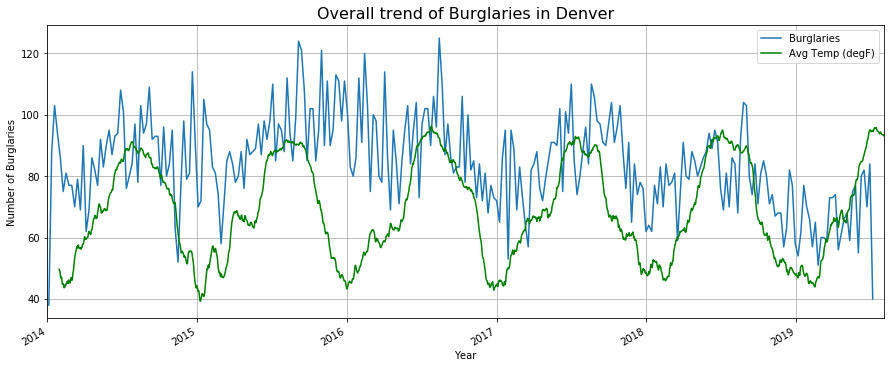

In [72]:
# Is Denver burglary seasonal? 
burgSum = denverCrimeOHE_df3['burglary'].resample('W').sum()

rollingTmax = denverMaxTemps_ts.rolling(window=30)
rollingTmax_mean = rollingTmax.mean()

plt.figure(figsize = (15,6))

plt.title('Overall trend of Burglaries in Denver', fontsize=16)
plt.ylabel('Number of Burglaries')
plt.xlabel('Year')
plt.plot(burgSum, label='Burglaries')
rollingTmax_mean.plot(color='green', label='Avg Temp (degF)')
plt.grid(True)
plt.legend()

In [74]:
# Resample the data on a weekly basis to match the temperature data
assSum = denverCrimeOHE_df3['aggravated-assault'].resample('W').sum()
aocSum = denverCrimeOHE_df3['all-other-crimes'].resample('W').sum()
arsSum = denverCrimeOHE_df3['arson'].resample('W').sum()
atSum = denverCrimeOHE_df3['auto-theft'].resample('W').sum()
burgSum = denverCrimeOHE_df3['burglary'].resample('W').sum()
daSum = denverCrimeOHE_df3['drug-alcohol'].resample('W').sum()
larcSum = denverCrimeOHE_df3['larceny'].resample('W').sum()
murdSum = denverCrimeOHE_df3['murder'].resample('W').sum()
ocpSum = denverCrimeOHE_df3['other-crimes-against-persons'].resample('W').sum()
pudiSum = denverCrimeOHE_df3['public-disorder'].resample('W').sum()
robSum = denverCrimeOHE_df3['robbery'].resample('W').sum()
sexSum = denverCrimeOHE_df3['sexual-assault'].resample('W').sum()
tmvSum = denverCrimeOHE_df3['theft-from-motor-vehicle'].resample('W').sum()
rtaSum = denverCrimeOHE_df3['traffic-accident'].resample('W').sum()
wccSum = denverCrimeOHE_df3['white-collar-crime'].resample('W').sum()

In [75]:
sumList=[assSum,aocSum,arsSum,atSum,burgSum,daSum,larcSum,murdSum,ocpSum,pudiSum,robSum,sexSum,tmvSum,rtaSum,wccSum]

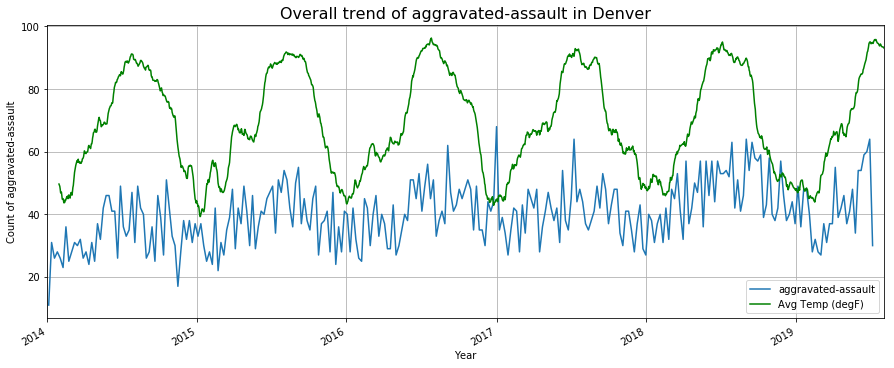

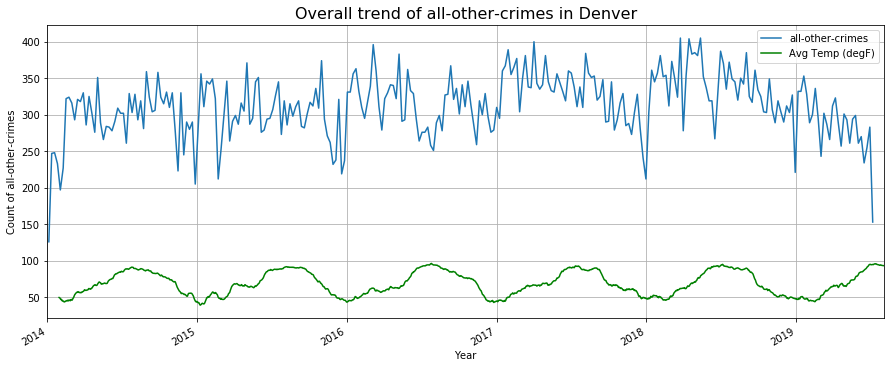

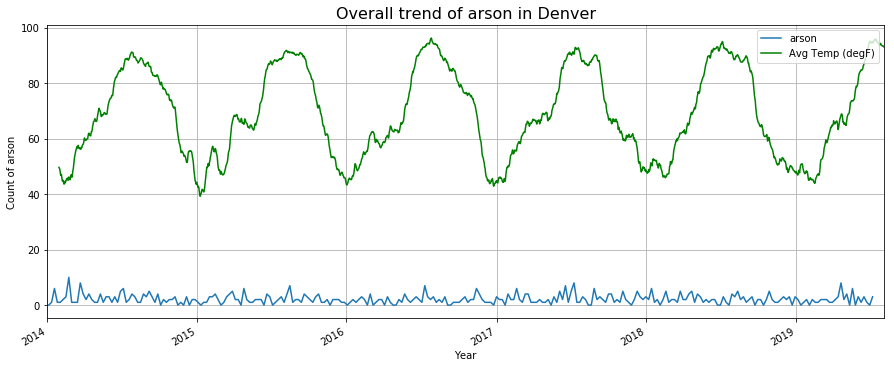

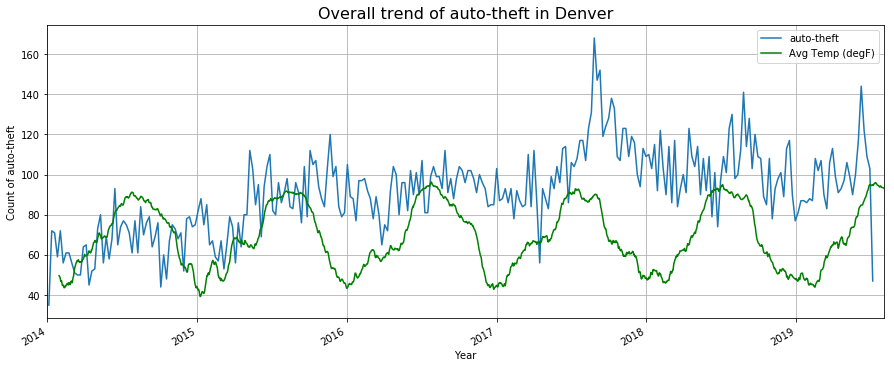

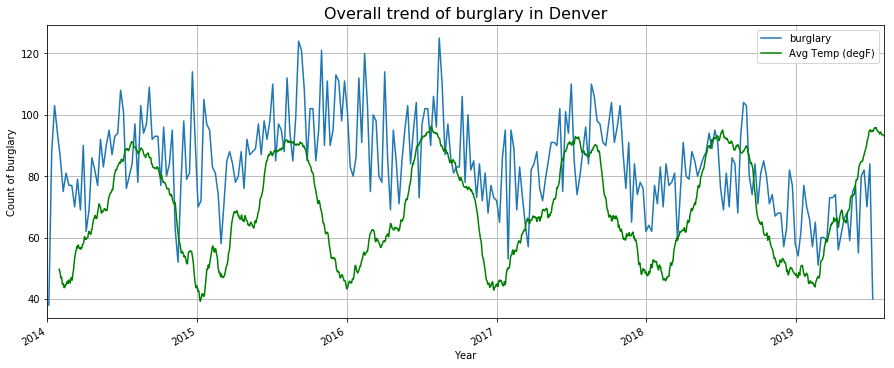

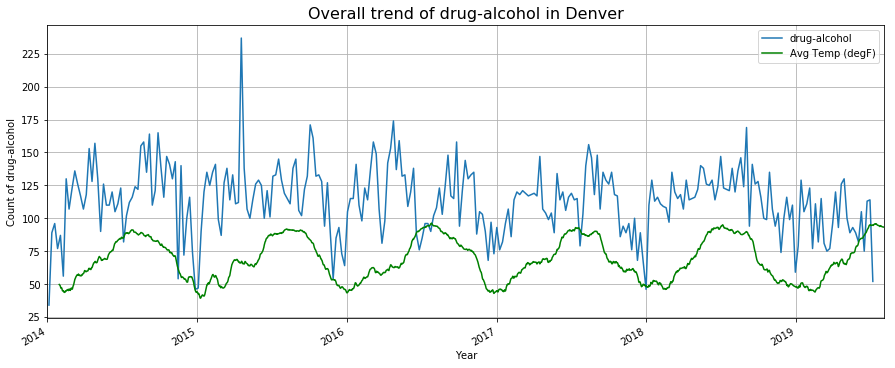

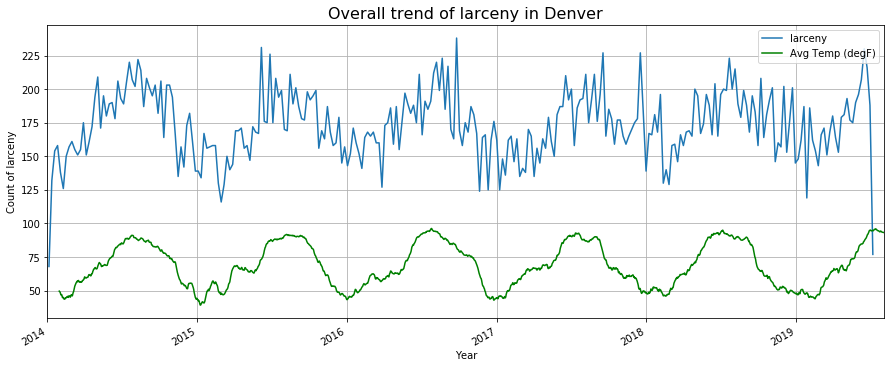

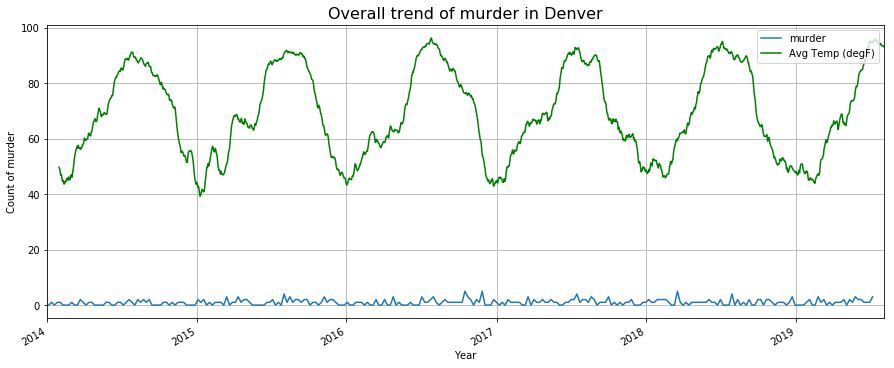

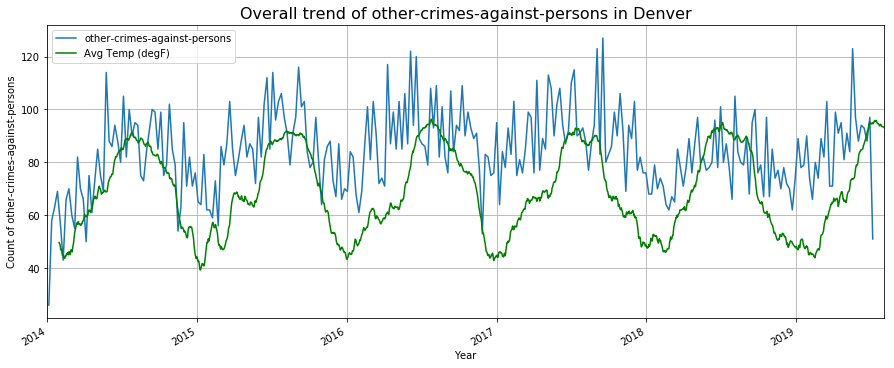

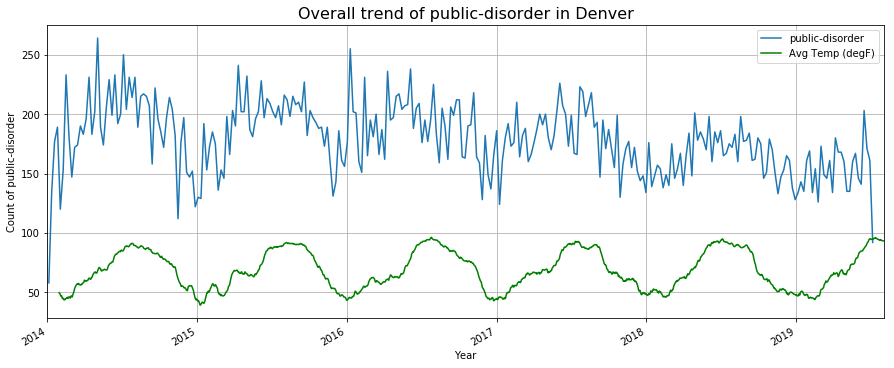

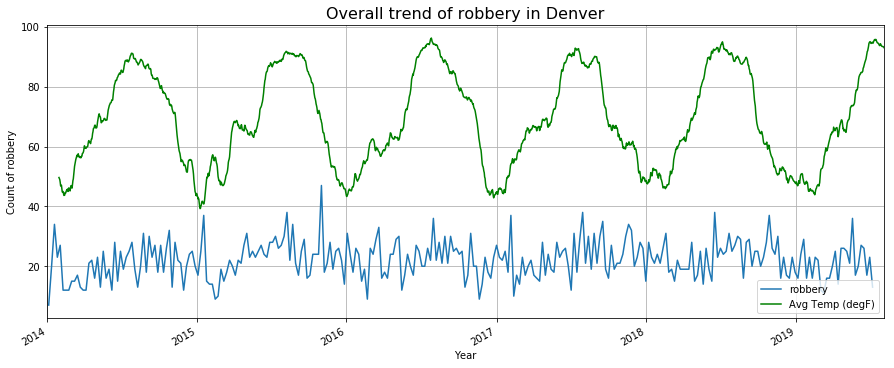

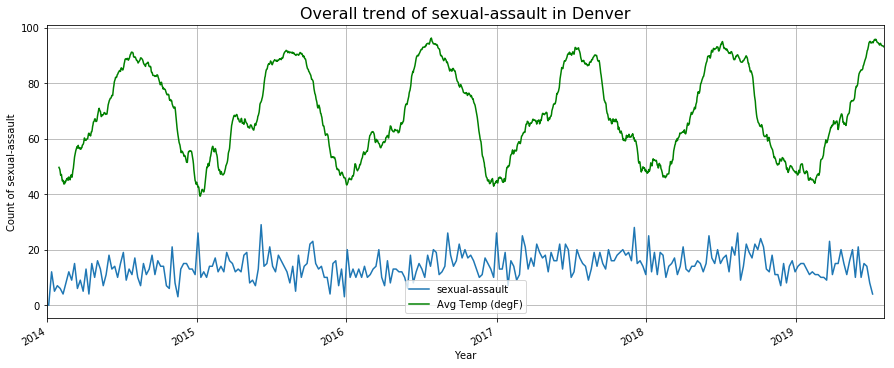

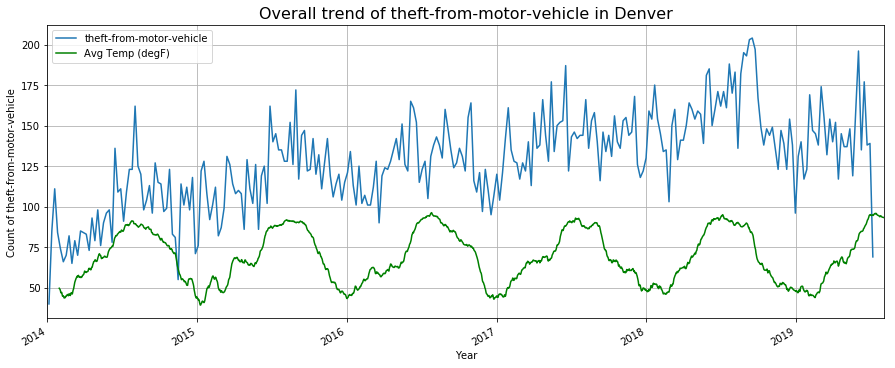

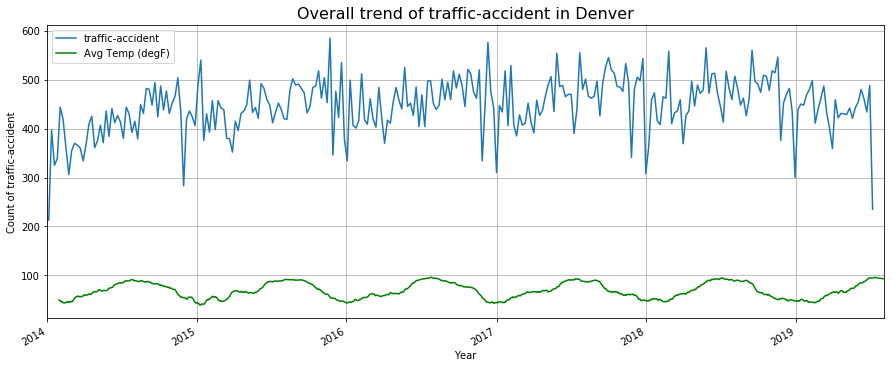

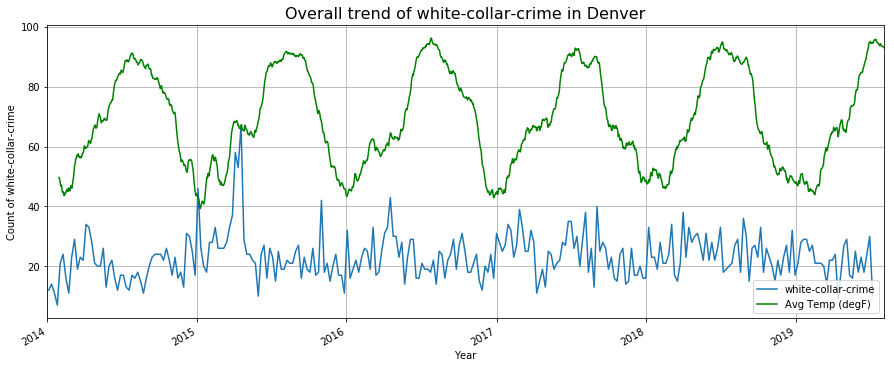

In [77]:
# let's look at the seasonality of the crime categories
rollingTmax = denverMaxTemps_ts.rolling(window=30)
rollingTmax_mean = rollingTmax.mean()

for i in range(len(sumList)):
    plt.figure(figsize = (15,6))
    plt.title('Overall trend of ' +list(label_encoder_OffenseCat.classes_)[i]+ ' in Denver', fontsize=16)
    plt.ylabel('Count of ' + list(label_encoder_OffenseCat.classes_)[i])
    plt.xlabel('Year')
    plt.plot(sumList[i], label=list(label_encoder_OffenseCat.classes_)[i])
    rollingTmax_mean.plot(color='green', label='Avg Temp (degF)')
    plt.grid(True)
    plt.legend()

In [ ]:
# Lets look at larceny...

In [78]:
# Test for Stationarity - does the data show a trend?
def stationarity_test(timeseries):
    """"Augmented Dickey-Fuller Test
    Test for Stationarity"""
    print("Results of Dickey-Fuller Test:")
    df_test = adfuller(timeseries, autolag = "AIC")
    df_output = pd.Series(df_test[0:4],
                          index = ["Test Statistic", "p-value", "#Lags Used",
                                   "Number of Observations Used"])
    print(df_output)

In [79]:
# larceny
denverLarc_ts = pd.Series(denverCrimeOHE_df3['larceny'].resample('W').sum(),
                     index = pd.date_range('2014-01-01',
                                           periods = 288,
                                           freq = 'W'))

In [80]:
stationarity_test(denverLarc_ts)

Results of Dickey-Fuller Test:
Test Statistic                  -5.398462
p-value                          0.000003
#Lags Used                      16.000000
Number of Observations Used    271.000000
dtype: float64


In [ ]:
# Dickey-Fuller results imply stationarity/no trend (p-value is < 0.05)

In [ ]:
# Is there auto-correlation in raw larceny data?

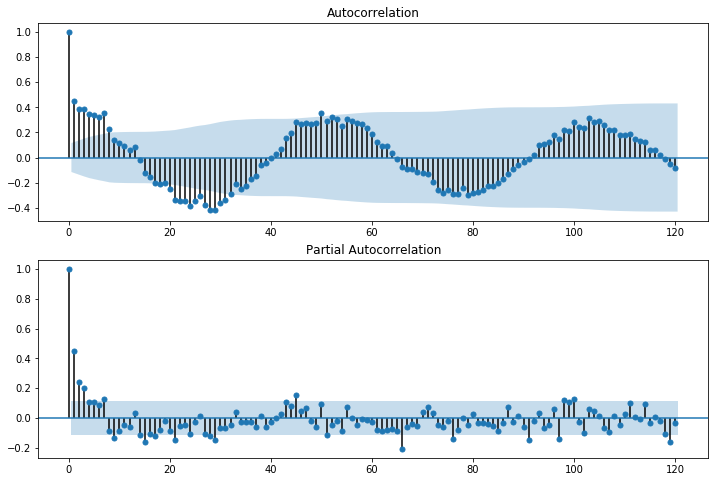

In [81]:
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = plot_acf(denverLarc_ts, lags=120, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf(denverLarc_ts, lags=120, ax=ax2)

In [ ]:
# lots of auto-correlation in the above

In [ ]:
# Perform seasonal decompostion and explore...

In [82]:
decompDenverLarc = seasonal_decompose(denverLarc_ts)

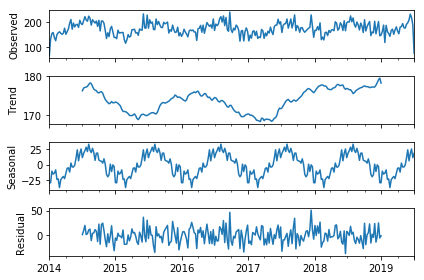

In [83]:
dplot = decompDenverLarc.plot()

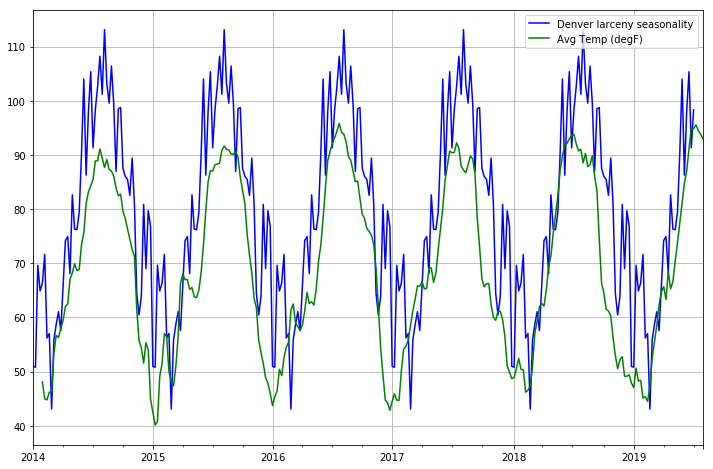

In [84]:
# is larceny seasonality driven by climate?
denverLarcSeasonAdj = decompDenverLarc.seasonal+80
plt.figure(figsize=(12,8))
denverLarcSeasonAdj.plot(color='blue', label='Denver larceny seasonality')
rollingTmax_mean.plot(color='green', label='Avg Temp (degF)')
plt.grid()
plt.legend()

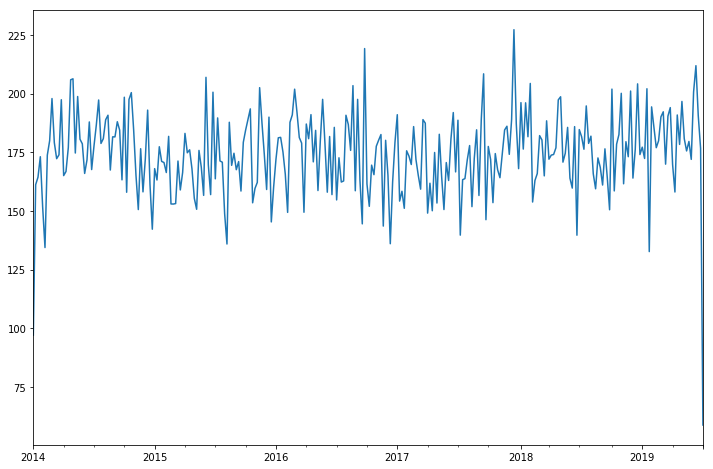

In [85]:
# but what about when seasonal element removed?
plt.figure(figsize=(12,8))
(decompDenverLarc.observed-decompDenverLarc.seasonal).plot()

In [ ]:
# If seasonality is climate-driven (i.e. we have fully identified the dependencies) then the residual should be random

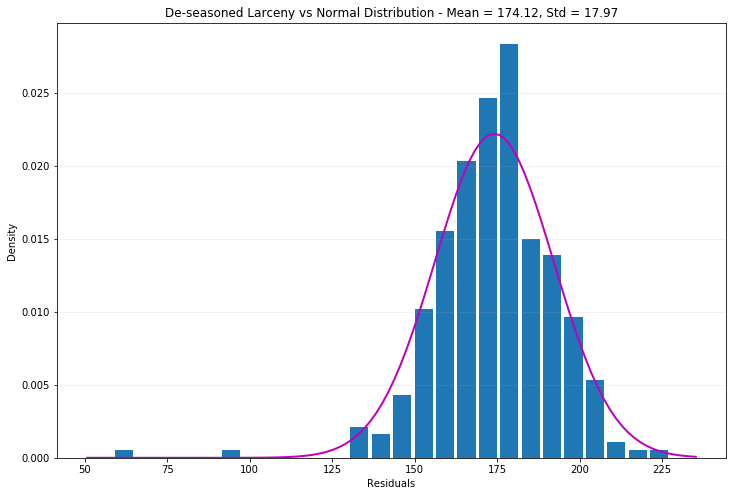

In [86]:
# Histogram of the Residuals
# Importing function for normal distribution
plt.figure(figsize = (12, 8))
plt.hist((decompDenverLarc.observed-decompDenverLarc.seasonal), bins = 'auto', density = True, rwidth = 0.85,
         label = 'De-seasonalised') #density TRUE - norm.dist bell curve
mu, std = norm.fit((decompDenverLarc.observed-decompDenverLarc.seasonal))
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100) #linspace returns evenly spaced numbers over a specified interval
p = norm.pdf(x, mu, std) #pdf = probability density function
plt.plot(x, p, 'm', linewidth = 2)
plt.grid(axis='y', alpha = 0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('De-seasoned Larceny vs Normal Distribution - Mean = '+str(round(mu,2))+', Std = '+str(round(std,2)))
plt.show()

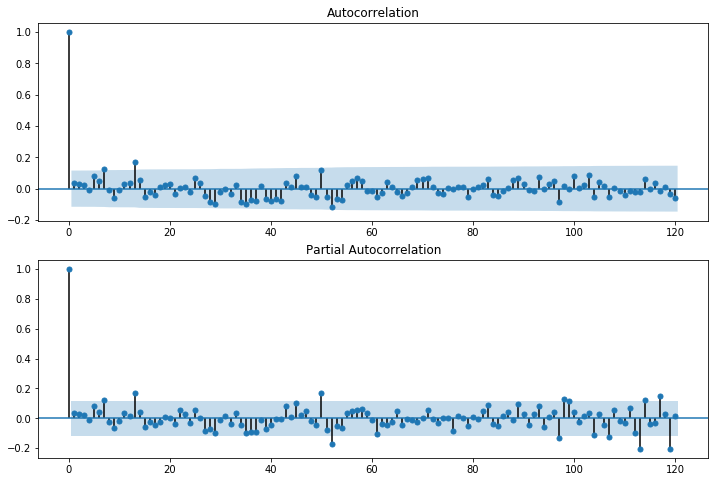

In [87]:
# is there auto-correlation with seasonality removed?
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(211)
fig = plot_acf((decompDenverLarc.observed-decompDenverLarc.seasonal), lags=120, ax=ax1)
ax2 = fig.add_subplot(212)
fig = plot_pacf((decompDenverLarc.observed-decompDenverLarc.seasonal), lags=120, ax=ax2)

In [ ]:
# how to make an ARIMA model for Denver burglaries

In [ ]:
"""
Here we're looking at p and q arguments for ARIMA: p for the auto-regression, and q for the moving average part.
These two interact quite a bit. So how do we test for auto-regression? It is a visual task with ACF and PACF
plots. The ACF plot excludes the autocorrelation of the shorter lags, the ACF does not.

The plot sheet shows both ACF and PACF plots. It is not always clear how to best start the parameter
selection process from these plots. It of course helps if you know the story behind the data.

Generally the ACF plot tells you the lags for the Moving Average (MA) parameter q, and PACF plot tells
you about the auto-regressive parameter p. However both interact with each other. Once you select one
parameter both the auto-regression and the moving average are affected.

Now in this particular case the ACF plot is outside the threshold, quite a lot. Therefore we should
start with the PACF plot which is significant at lags 7 and 13. We will test them
later on when you have plots like these, you always start with a plot that shows the least amount of
lags outside the benchmark.

It is very important: PACF is the indicator for the auto-regression, p
ACF is the indicator for the moving average part, q
"""

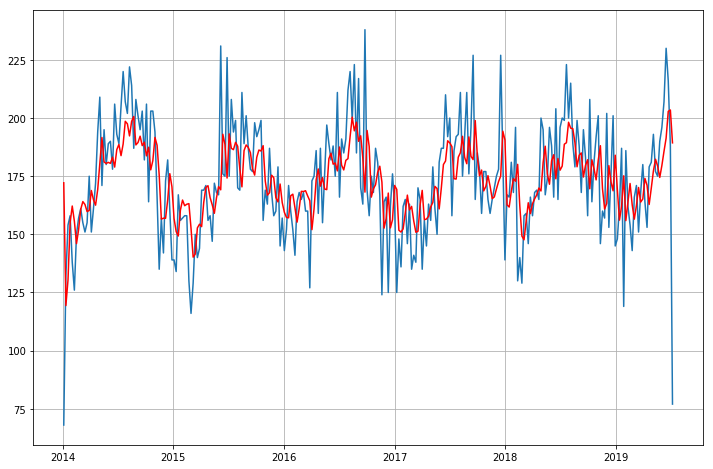

In [88]:
# Using ARIMA for the model, with the argument 'order'
# It is easy to change parameters
model = ARIMA(denverLarc_ts, order=(2, 0, 0))  
results_AR = model.fit()
plt.figure(figsize=(12,8))
plt.grid(True)

#plt.legend([mylynxts,results_AR.fittedvalues],['Original data','Model data'])
plt.plot(denverLarc_ts, label = 'Original data')
plt.plot(results_AR.fittedvalues, color='red', label = 'Model data')

In [89]:
# ARIMA Model Diagnostics
results_AR.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                larceny   No. Observations:                  288
Model:                     ARMA(2, 0)   Log Likelihood               -1291.548
Method:                       css-mle   S.D. of innovations             21.431
Date:                Thu, 05 Dec 2019   AIC                           2591.096
Time:                        09:52:42   BIC                           2605.748
Sample:                    01-05-2014   HQIC                          2596.967
                         - 07-07-2019                                         
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           172.1580      3.427     50.237      0.000     165.441     178.875
ar.L1.larceny     0.3774      0.061      6.183      0.000       0.258       0.497
ar.L2.larceny     0.2555      0.061      4.164      0.000       0.135       0.376
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.3732           +0.0000j            1.3732            0.0000
AR.2           -2.8503           +0.0000j            2.8503            0.5000
-----------------------------------------------------------------------------
"""

In [ ]:
"""
Two important pieces of data to get from the summary are:
AIC - Akaike Information Criteria https://en.wikipedia.org/wiki/Akaike_information_criterion
BIC - Base Informaton Criteria
They are measures of model quality and  - the simpler the better to avoid over-fitting
When comparing models, pick the one with the lowest AIC
"""

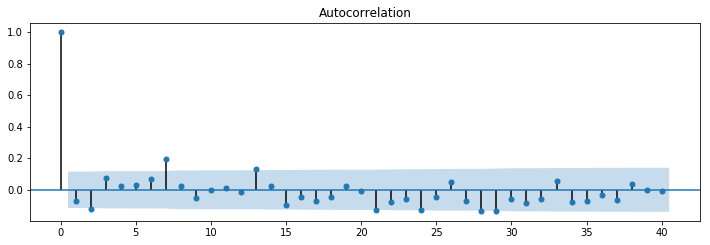

In [90]:
# ACF on Residuals of Our Model
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_AR.resid, lags=40, ax=ax1)

In [ ]:
# significance still showing at lags 2, 7 and 13 - we can probably improve model therefore
# lags at the front indicate significant need to improve model. Lags at the end may just be coincidence

In [ ]:
"""
AN IMPORTANT TEST OF MODEL QUALITY IS THAT THERE SHOULD BE NO PATTERN IN THE RESIDUALS - THEY MUST BE RANDOM
Apply ACF to the residuals to test this
"""

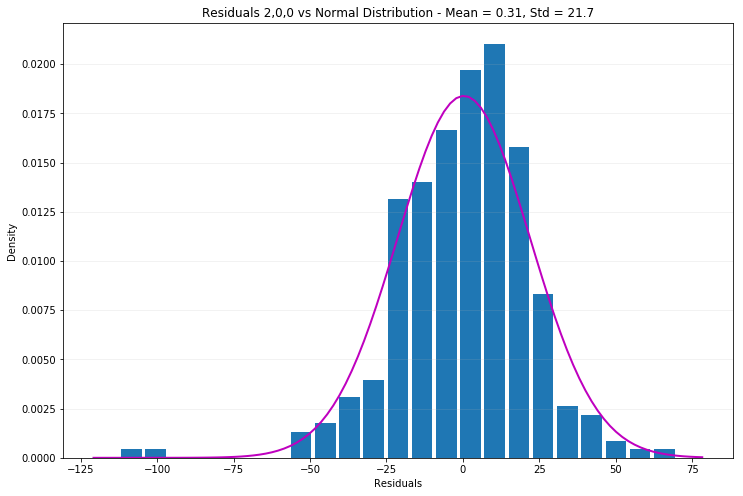

In [91]:
# Histogram of the Residuals
# Importing function for normal distribution
plt.figure(figsize = (12, 8))
plt.hist(results_AR.resid, bins = 'auto', density = True, rwidth = 0.85,
         label = 'Residuals') #density TRUE - norm.dist bell curve
mu, std = norm.fit(results_AR.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100) #linspace returns evenly spaced numbers over a specified interval
p = norm.pdf(x, mu, std) #pdf = probability density function
plt.plot(x, p, 'm', linewidth = 2)
plt.grid(axis='y', alpha = 0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals 2,0,0 vs Normal Distribution - Mean = '+str(round(mu,2))+', Std = '+str(round(std,2)))
plt.show()

In [ ]:
# the above is a little skewed, not a perfect normal distribution, therefore residuals not totally random

In [ ]:
# We can readjust the model as often as we like
# Repeat the following procedure for models AR(3), AR(4) and AR(5)
# Which one is the most promising? Look for the lowest AIC

In [92]:
pVar = [3,4,5,6,7]
for var in pVar:
    model = ARIMA(denverLarc_ts, order=(var, 0, 0))  
    results_AR = model.fit()
    print(results_AR.summary())

                              ARMA Model Results                              
Dep. Variable:                larceny   No. Observations:                  288
Model:                     ARMA(3, 0)   Log Likelihood               -1286.436
Method:                       css-mle   S.D. of innovations             21.050
Date:                Thu, 05 Dec 2019   AIC                           2582.872
Time:                        09:52:58   BIC                           2601.186
Sample:                    01-05-2014   HQIC                          2590.211
                         - 07-07-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           171.6948      4.218     40.705      0.000     163.428     179.962
ar.L1.larceny     0.3190      0.063      5.094      0.000       0.196       0.442
ar.L2.larceny     0.1854      0.064     

                              ARMA Model Results                              
Dep. Variable:                larceny   No. Observations:                  288
Model:                     ARMA(7, 0)   Log Likelihood               -1279.971
Method:                       css-mle   S.D. of innovations             20.570
Date:                Thu, 05 Dec 2019   AIC                           2577.941
Time:                        09:52:59   BIC                           2610.908
Sample:                    01-05-2014   HQIC                          2591.152
                         - 07-07-2019                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           170.4108      6.776     25.148      0.000     157.129     183.692
ar.L1.larceny     0.2629      0.064      4.113      0.000       0.138       0.388
ar.L2.larceny     0.1252      0.066     

In [ ]:
# AR 6 looks best. Lets examine the residuals in more detail:

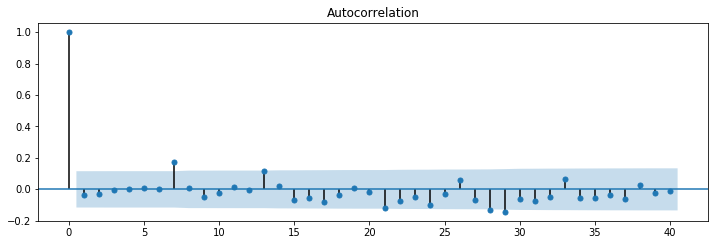

In [93]:
model = ARIMA(denverLarc_ts, order=(6, 0, 0))  
results_AR = model.fit()

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = plot_acf(results_AR.resid, lags=40, ax=ax1)

In [ ]:
# still borderline - lags 7 and 13 still fall outside (1 outlier acceptable)

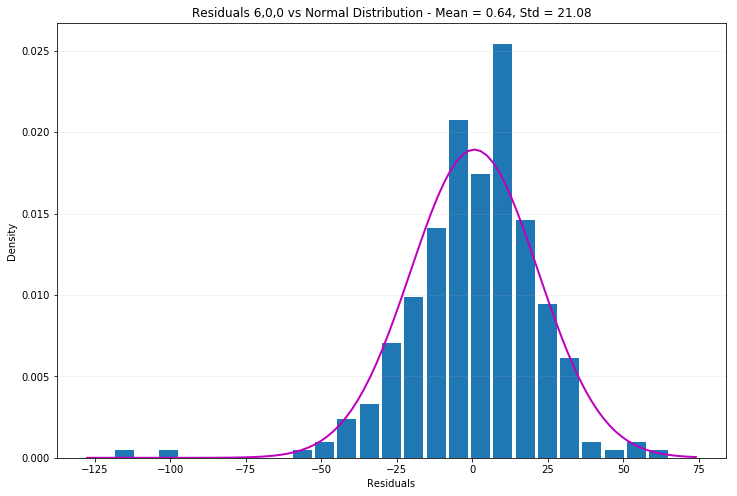

In [31]:
# check the randomness of the residuals again
plt.figure(figsize = (12, 8))
plt.hist(results_AR.resid, bins = 'auto', density = True, rwidth = 0.85,
         label = 'Residuals') #density TRUE - norm.dist bell curve
mu, std = norm.fit(results_AR.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100) #linspace returns evenly spaced numbers over a specified interval
p = norm.pdf(x, mu, std) #pdf = probability density function
plt.plot(x, p, 'm', linewidth = 2)
plt.grid(axis='y', alpha = 0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals 6,0,0 vs Normal Distribution - Mean = '+str(round(mu,2))+', Std = '+str(round(std,2)))
plt.show()

In [ ]:
# not much of an improvement over the 2,0,0. Lets have a look at their forecasts

In [32]:
# Setting up an ARIMA(2,0,0) model and storing its fitted values
model_AR200 = ARIMA(denverLarc_ts, order=(2, 0, 0))  
results_AR200 = model_AR200.fit()

In [33]:
# Forecast based on the ARIMA(2,0,0) model
Fcast200 = results_AR200.predict(start = '2019',
                               end = '2021')
# NOTE: Forecasts have a built-in timestamp

In [34]:
# Setting up an ARIMA(2,0,0) model and storing its fitted values
model_AR600 = ARIMA(denverLarc_ts, order=(6, 0, 0))  
results_AR600 = model_AR600.fit()

In [35]:
Fcast600 = results_AR600.predict(start = '2019',
                               end = '2021')

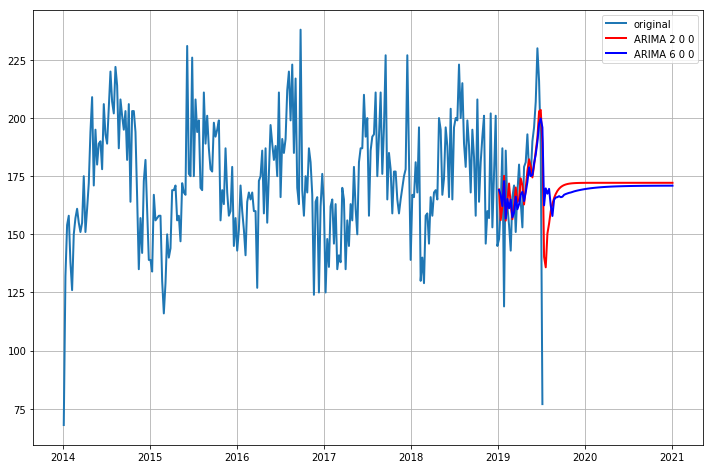

In [36]:
# Comparing the forecasts via data visualization
plt.figure(figsize = (12, 8))
plt.plot(denverLarc_ts, linewidth = 2, label = "original")
plt.plot(Fcast200, color='red', linewidth = 2,
         label = "ARIMA 2 0 0")
plt.plot(Fcast600, color='blue', linewidth = 2,
         label = "ARIMA 6 0 0")
plt.grid()
plt.legend()

In [ ]:
# Not a great performance with ARIMA :(
# Does seasonal decomposition do any better?

In [ ]:
# seasonal decomposition with stl package

In [37]:
stl_DenvLarc = decompose(denverLarc_ts, period=52) # 52 because the data has been binned into weeks

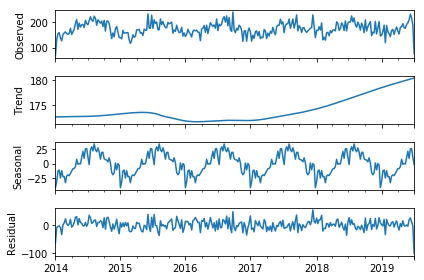

In [38]:
stlvisual = stl_DenvLarc.plot()

In [39]:
stl_DenvLarc.resid

2014-01-05    -63.257101
2014-01-12     -9.570636
2014-01-19     -5.884171
2014-01-26     -3.527526
2014-02-02     -9.837548
                 ...    
2019-06-09     17.858748
2019-06-16     24.486982
2019-06-23      9.946415
2019-06-30     -3.260819
2019-07-07   -101.804086
Freq: W-SUN, Name: Larc, Length: 288, dtype: float64

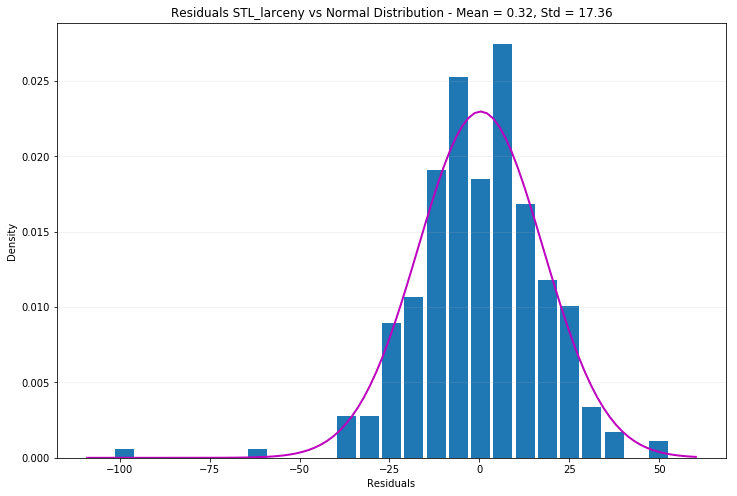

In [40]:
# check the randomness of the residuals again
plt.figure(figsize = (12, 8))
plt.hist(stl_DenvLarc.resid, bins = 'auto', density = True, rwidth = 0.85,
         label = 'Residuals') #density TRUE - norm.dist bell curve
mu, std = norm.fit(stl_DenvLarc.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100) #linspace returns evenly spaced numbers over a specified interval
p = norm.pdf(x, mu, std) #pdf = probability density function
plt.plot(x, p, 'm', linewidth = 2)
plt.grid(axis='y', alpha = 0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals STL_larceny vs Normal Distribution - Mean = '+str(round(mu,2))+', Std = '+str(round(std,2)))
plt.show()

In [41]:
fcast_DenvLarc = forecast(stl_DenvLarc, steps=52, fc_func=seasonal_naive, seasonal = True)

In [42]:
fcast_DenvLarc.head()

,seasonal_naive+seasonal
2019-07-14,203.172173
2019-07-21,208.828474
2019-07-28,201.884537
2019-08-04,213.944881
2019-08-11,204.205087


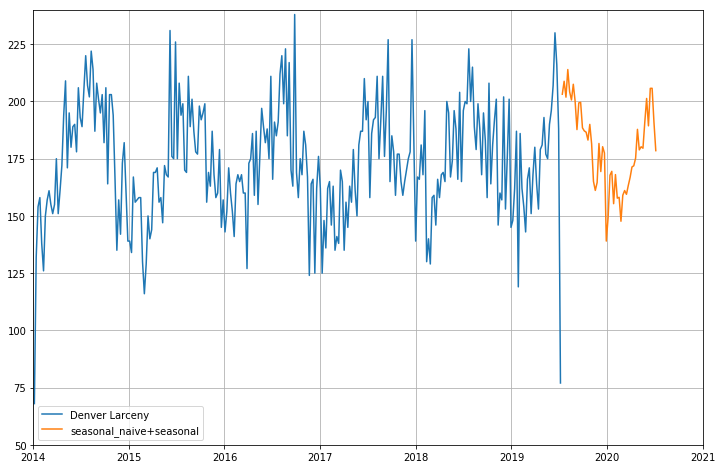

In [43]:
# Plot of the forecast and the original data
plt.figure(figsize=(12,8))
plt.plot(denverLarc_ts, label='Denver Larceny')
plt.plot(fcast_DenvLarc, label=fcast_DenvLarc.columns[0])
plt.xlim('2014','2021'); plt.ylim(50,240);
plt.grid(True)
plt.legend()

In [44]:
# Perform exponential smoothing
# Setting up the exponential smoothing model (A,N,A) - additive level, no trend, additive seasonality
expsmodel_DenvLarc = ExponentialSmoothing(denverLarc_ts, seasonal = "additive",
                                 seasonal_periods = 52)

In [45]:
# Fit model
expsmodelfit_DenvLarc = expsmodel_DenvLarc.fit()

C:\Users\ianda\Anaconda3\lib\site-packages\statsmodels\tsa\holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


In [46]:
# Alpha smoothing coefficient
expsmodelfit_DenvLarc.params['smoothing_level']

4.166331207281169e-25

In [47]:
# Gamma smoothing coefficient
expsmodelfit_DenvLarc.params['smoothing_seasonal']

0.0

In [ ]:
# coeffs are close or equal to zero. Not surprising as larceny data is fairly smooth - no trends

In [52]:
# Prediction with exponential smoothing
expsfcast_DenvLarc = expsmodelfit_DenvLarc.predict(start = 281, end = 450)

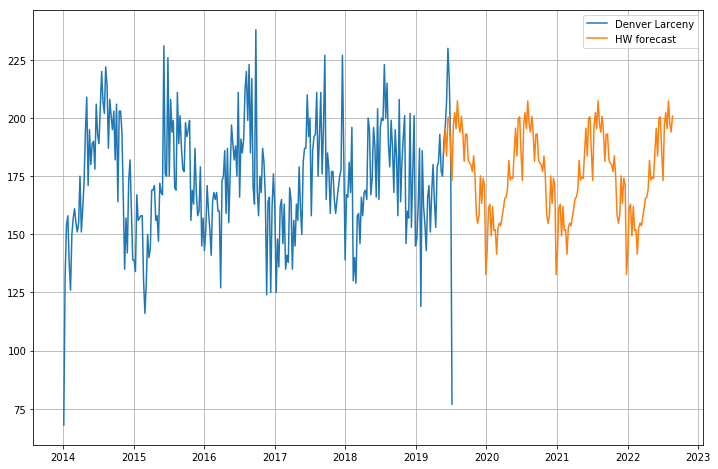

In [53]:
# Plotting the predicted values and the original data
plt.figure(figsize=(12,8))
plt.plot(denverLarc_ts, label='Denver Larceny')
plt.plot(expsfcast_DenvLarc, label='HW forecast')
plt.grid(True)
plt.legend()

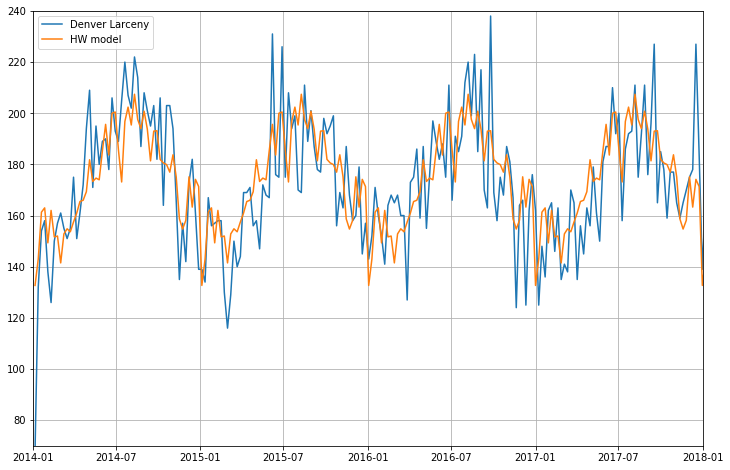

In [54]:
# Comparing the model to the original values
# How good is the model fit?
plt.figure(figsize=(12,8))
plt.plot(denverLarc_ts, label='Denver Larceny')
plt.plot(expsmodelfit_DenvLarc.fittedvalues, label='HW model')
plt.grid(True)
plt.xlim('2014','2018'); plt.ylim(70,240);
plt.legend()

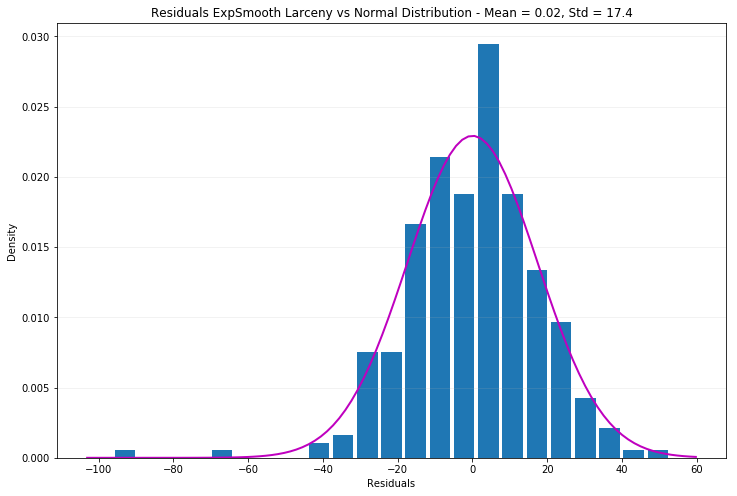

In [55]:
# check the randomness of the residuals again
plt.figure(figsize = (12, 8))
plt.hist(expsmodelfit_DenvLarc.resid, bins = 'auto', density = True, rwidth = 0.85,
         label = 'Residuals') #density TRUE - norm.dist bell curve
mu, std = norm.fit(expsmodelfit_DenvLarc.resid)
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100) #linspace returns evenly spaced numbers over a specified interval
p = norm.pdf(x, mu, std) #pdf = probability density function
plt.plot(x, p, 'm', linewidth = 2)
plt.grid(axis='y', alpha = 0.2)
plt.xlabel('Residuals')
plt.ylabel('Density')
plt.title('Residuals ExpSmooth Larceny vs Normal Distribution - Mean = '+str(round(mu,2))+', Std = '+str(round(std,2)))
plt.show()